In [1]:
import os
import sys
import subprocess
import random
import pyft
import pandas as pd
import seaborn as sns
import altair as alt
import altair_saver
import matplotlib as plt
from brokenaxes import brokenaxes
from collections import Counter
from statistics import mean, median, mode
sys.path.append('/gscratch/stergachislab/bmallo/large_home/python_scripts/')
from pyft_analysis import get_nuc_lengths, get_nuc_lengths_by_nuc_count, get_npr, get_read_lengths, get_percent_methylated

### Import data

In [2]:
# Raw methylated_bam is non-transfected pEF-GFP that was Fiber-seq'd with no m6a or length filters applied (x reads)
raw_methylated_bam = '/gscratch/stergachislab/bmallo/large_home/ft_data/plasmid_fiberseq/non_transfected_plasmid_controls/methylated_pEF-GFP/plasmid_bams_processed/pEFGFP/all_pEF-GFP_reads.bam'

# Methylated_bam is non-transfected pEF-GFP that was Fiber-seq'd (228,840 reads)
methylated_bam = '/gscratch/stergachislab/bmallo/large_home/ft_data/plasmid_fiberseq/non_transfected_plasmid_controls/methylated_pEF-GFP/plasmid_bams_processed/pEFGFP/pEFGFP_no_m6a_filter_50_range_exact_reads.bam'

# non_methylated_bam is non-transfected pEF-GFP that was not Fiber-seq'd. AKA this is pEF-GFP from ER2796 (465,973 reads)
non_methylated_bam = '/gscratch/stergachislab/bmallo/large_home/ft_data/plasmid_fiberseq/non_transfected_plasmid_controls/non_methylated_pEF-GFP/plasmid_bams_processed/pEFGFP/pEFGFP_no_m6a_filter_50_range_exact_reads.bam'   

# raw_pEF-GFP_Hek293 is transfected pEF-GFP that was Fiber-seq'd with no m6a or length filters applied (804,348 reads)
raw_pEF_GFP_Hek293 = '/gscratch/stergachislab/bmallo/large_home/ft_data/plasmid_fiberseq/pEF_GFP_Gus/rep_3/plasmid_bams_processed/pEFGFP/all_pEF-GFP_reads.bam'

# pEF-GFP_Hek293 is transfected pEF-GFP that was Fiber-seq'd (605,984 reads)
pEF_GFP_Hek293 = '/gscratch/stergachislab/bmallo/large_home/ft_data/plasmid_fiberseq/pEF_GFP_Gus/rep_3/plasmid_bams_processed/pEFGFP/pEFGFP_no_m6a_filter_50_range_exact_read.bam'

# Also want to compare how the m6a filter changes percent m6a and NPR. Can't filter unmethylated reads. (methylated = 226,245 reads, pEF-GFP_Hek293 = 382,759 reads)
methylated_bam_m6a_filtered = '/gscratch/stergachislab/bmallo/large_home/ft_data/plasmid_fiberseq/non_transfected_plasmid_controls/methylated_pEF-GFP/plasmid_bams_processed/pEFGFP/pEFGFP_50_range_exact_reads.bam'
pEF_GFP_Hek293_bam_m6a_filtered = '/gscratch/stergachislab/bmallo/large_home/ft_data/plasmid_fiberseq/pEF_GFP_Gus/rep_3/plasmid_bams_processed/pEFGFP/pEFGFP_50_range_exact_aligned.bam'

In [8]:
# untransfected 
untransfected_all_reads = '/gscratch/stergachislab/bmallo/large_home/ft_data/plasmid_fiberseq/non_transfected_plasmid_controls/methylated_pEF-GFP/plasmid_bams_processed/pEFGFP/all_pEF-GFP_reads.bam'
untransfected_length_filtered = '/gscratch/stergachislab/bmallo/large_home/ft_data/plasmid_fiberseq/non_transfected_plasmid_controls/methylated_pEF-GFP/plasmid_bams_processed/pEFGFP/pEFGFP_no_m6a_filter_50_range_exact_reads.bam'
untransfected_length_m6a_filtered = '/gscratch/stergachislab/bmallo/large_home/ft_data/plasmid_fiberseq/non_transfected_plasmid_controls/methylated_pEF-GFP/plasmid_bams_processed/pEFGFP/pEFGFP_50_range_exact_reads.bam'

# transfected
transfected_all_reads = '/gscratch/stergachislab/bmallo/large_home/ft_data/plasmid_fiberseq/pEF_GFP_Gus/rep_3/plasmid_bams_processed/pEFGFP/subsampled_all_pEF-GFP_reads.bam'
transfected_length_filtered = '/gscratch/stergachislab/bmallo/large_home/ft_data/plasmid_fiberseq/pEF_GFP_Gus/rep_3/plasmid_bams_processed/pEFGFP/subsample_no_m6a_filter_50_range_exact_read.bam'
transfected_length_m6a_filtered= '/gscratch/stergachislab/bmallo/large_home/ft_data/plasmid_fiberseq/pEF_GFP_Gus/rep_3/plasmid_bams_processed/pEFGFP/subsample_lenght_m6a_filtered.bam'

### Helper Functions

In [3]:
def get_total_reads(input_bam):
    # Use samtools to get total read count
    cmd = ["samtools", "view", "-c", input_bam]
    total_reads = int(subprocess.check_output(cmd).strip())
    return total_reads

def analyze_bam(input_bam, analysis_module):
    """ 
    Runs the provided analysis module on a BAM file.

    Args:
        input_bam (str): Full path to the input BAM file.
        analysis_module (function): A function that will perform analysis on the BAM file. 
                                    Example: `get_nuc_lengths` from `pyft_analysis`.
    """   

    # Read in input_bam as pyft fiberbam object
    fiberbam = pyft.Fiberbam(input_bam)

    # Run analysis module on bam file
    result = analysis_module(fiberbam)

    return result

def analyze_subsampled_bam(input_bam, analysis_module, num_reads=None, iterations=1, output_dir="/tmp"):

    """ 
    Subsamples a BAM file and runs the provided analysis module on each subsample.

    Args:
        input_bam (str): Full path to the input BAM file.
        analysis_module (function): A function that will perform analysis on each subsampled BAM file. 
                                    Example: `get_nuc_lengths` from `pyft_analysis`.
        num_reads (int or None): The number of reads to subsample from the input BAM file in each iteration. Default is None which results 
                                  in all reads being used in a single iteration.
        iterations (int or None): The number of iterations to perform. In each iteration, a new subsample will be taken. Default is 1.
        output_dir (str): The directory to store temporary BAM files. Default is "/tmp".

    Notes:
        If you care about read length, it's probably easiest to start with a length filtered bam file.
    """   

    # Get fraction corresponding to num_reads
    fraction = (num_reads / get_total_reads(input_bam))
    fraction = (str(fraction).split(".")[1])
    print(fraction)

    # Initialize a dictionary to store module outputs
    results_dict = {}

    for i in range(iterations):
        # Generate a unique random seed for subsampling
        random_seed = i + 1

        # Define a path for the temporary BAM file 
        temp_bam_path = os.path.join(output_dir, f"temp_subsample_{i}.bam")

        # Call samtools to subsample reads
        cmd = [
            "samtools", "view", "-s", f"{random_seed}.{fraction}", "-b", input_bam, "-o", temp_bam_path
        ]

        print(cmd)
        subprocess.run(cmd, check=True)

        # Index the temporary BAM file
        subprocess.run(["samtools", "index", temp_bam_path], check=True)

        # Read in temp_bam as pyft fiberbam object
        fiberbam = pyft.Fiberbam(temp_bam_path)

        # Run analysis module on bam file
        result = analysis_module(fiberbam)
        results_dict[i] = result

        # Remove temporary BAM file
        if os.path.exists(temp_bam_path):
            os.remove(temp_bam_path)
        if os.path.exists(f"{temp_bam_path}.bai"):
            os.remove(f"{temp_bam_path}.bai")

    return results_dict

### get m6a data

In [9]:
untransfected_all_reads_m6a = analyze_bam(untransfected_all_reads, get_percent_methylated)
untransfected_length_filtered_m6a = analyze_bam(untransfected_length_filtered, get_percent_methylated)
untransfected_length_m6a_filtered_m6a = analyze_bam(untransfected_length_m6a_filtered, get_percent_methylated)
transfected_all_reads_m6a = analyze_bam(transfected_all_reads, get_percent_methylated)
transfected_length_filtered_m6a = analyze_bam(transfected_length_filtered, get_percent_methylated)
transfected_length_m6a_filtered_m6a = analyze_bam(transfected_length_m6a_filtered, get_percent_methylated)

In [6]:
# Get percent methlation of reads from each sample, normalizing for the smallest number of reads (226,245 reads)
# non_methylated_m6a = analyze_subsampled_bam(non_methylated_bam, get_percent_methylated, num_reads=226245)
raw_methylated_m6a = analyze_subsampled_bam(raw_methylated_bam, get_percent_methylated, num_reads=304738)
# methylated_m6a = analyze_subsampled_bam(methylated_bam, get_percent_methylated, num_reads=226245)
# methylated_m6a_filtered = analyze_subsampled_bam(methylated_bam_m6a_filtered, get_percent_methylated, num_reads=226245)
raw_pEF_GFP_Hek293_m6a = analyze_subsampled_bam(raw_pEF_GFP_Hek293, get_percent_methylated, num_reads=304738)
# pEF_GFP_Hek293_m6a = analyze_subsampled_bam(pEF_GFP_Hek293, get_percent_methylated, num_reads=226245)
# pEF_GFP_Hek293_m6a_filtered = analyze_subsampled_bam(pEF_GFP_Hek293_bam_m6a_filtered, get_percent_methylated, num_reads=226245)

0
['samtools', 'view', '-s', '1.0', '-b', '/gscratch/stergachislab/bmallo/large_home/ft_data/plasmid_fiberseq/non_transfected_plasmid_controls/methylated_pEF-GFP/plasmid_bams_processed/pEFGFP/all_pEF-GFP_reads.bam', '-o', '/tmp/temp_subsample_0.bam']
3788633775430535
['samtools', 'view', '-s', '1.3788633775430535', '-b', '/gscratch/stergachislab/bmallo/large_home/ft_data/plasmid_fiberseq/pEF_GFP_Gus/rep_3/plasmid_bams_processed/pEFGFP/all_pEF-GFP_reads.bam', '-o', '/tmp/temp_subsample_0.bam']


In [ ]:
# Samtools subsampling does not get exact number of reads, so I am truncating the list to the length of the smallest sample
# len(non_methylated_m6a[0]), len(methylated_m6a[0]), len(methylated_m6a_filtered[0]), len(pEF_GFP_Hek293_m6a[0]), len(pEF_GFP_Hek293_m6a_filtered[0])
# non_methylated_m6a[0] = non_methylated_m6a[0][:226245]
raw_methylated_m6a[0] = raw_methylated_m6a[0][:304738]
# methylated_m6a[0] = methylated_m6a[0][:226245]
# methylated_m6a_filtered[0] = methylated_m6a_filtered[0][:226245]
raw_pEF_GFP_Hek293_m6a[0] = raw_pEF_GFP_Hek293_m6a[0][:304738]
# pEF_GFP_Hek293_m6a[0] = pEF_GFP_Hek293_m6a[0][:226245]
# pEF_GFP_Hek293_m6a_filtered[0] = pEF_GFP_Hek293_m6a_filtered[0][:226245]

#### get read length data

In [10]:
untransfected_all_reads_read_lengths = analyze_bam(untransfected_all_reads, get_read_lengths)
untransfected_length_filtered_read_lengths = analyze_bam(untransfected_length_filtered, get_read_lengths)
untransfected_length_m6a_filtered_read_lengths = analyze_bam(untransfected_length_m6a_filtered, get_read_lengths)
transfected_all_reads_read_lengths = analyze_bam(transfected_all_reads, get_read_lengths)
transfected_length_filtered_read_lengths = analyze_bam(transfected_length_filtered, get_read_lengths)
transfected_length_m6a_filtered_read_lengths = analyze_bam(transfected_length_m6a_filtered, get_read_lengths)

read_count = 304738 mean = 4675 median = 5057.0 mode = 5058
read_count = 228840 mean = 5057 median = 5058.0 mode = 5058
read_count = 226245 mean = 5057 median = 5058 mode = 5058
read_count = 305645 mean = 4873 median = 5058 mode = 5058
read_count = 252765 mean = 5057 median = 5058 mode = 5058
read_count = 160317 mean = 5057 median = 5058 mode = 5058


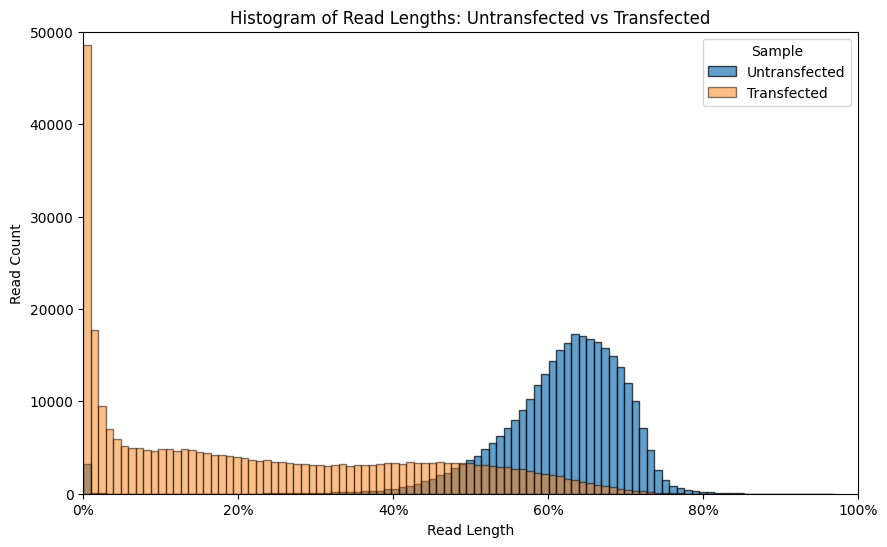

In [71]:
from matplotlib.ticker import FuncFormatter

# Define the bins for the histogram
# bins = range(0, 1, 100)  # Adjust as needed for your data

# Create the broken y-axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the histograms for each sample
# Use the same bins for both histograms to ensure alignment
bins = 100
range_min = min(min(untransfected_all_reads_m6a), min(transfected_all_reads_m6a))
range_max = max(max(untransfected_all_reads_m6a), max(transfected_all_reads_m6a))
bin_range = (range_min, range_max)

ax.hist(untransfected_all_reads_m6a, bins=bins, range=bin_range, alpha=0.7, label='Untransfected', edgecolor='black', color='#1f77b4')
ax.hist(transfected_all_reads_m6a, bins=bins, range=bin_range, alpha=0.5, label='Transfected', edgecolor='black', color='#ff7f0e')

# Add legend
ax.legend(title="Sample")

# Add labels and title
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0%}'))
ax.set_xlabel('Read Length')
ax.set_ylabel('Read Count')
ax.set_title('Histogram of Read Lengths: Untransfected vs Transfected')
ax.set_ylim(0, 50000)
ax.set_xlim(0, 1)
ax.legend(title="Sample")

fig.savefig('/gscratch/stergachislab/bmallo/large_home/plasmid_fiberseq/paper_figures/figure_1/supplemental/all_reads_m6a.pdf')

In [ ]:
# non_methylated_read_length = analyze_subsampled_bam(non_methylated_bam, get_read_lengths, num_reads=226245)
raw_methylated_read_length = analyze_subsampled_bam(raw_methylated_bam, get_read_lengths, num_reads=226245)
# methylated_read_length = analyze_subsampled_bam(methylated_bam, get_read_lengths, num_reads=226245)
# methylated_read_length_filtered = analyze_subsampled_bam(methylated_bam_m6a_filtered, get_read_lengths, num_reads=226245)
raw_pEF_GFP_Hek293_read_length = analyze_subsampled_bam(raw_pEF_GFP_Hek293, get_read_lengths, num_reads=226245)
# pEF_GFP_Hek293_read_length = analyze_subsampled_bam(pEF_GFP_Hek293, get_read_lengths, num_reads=226245)
# pEF_GFP_Hek293_read_length_filtered = analyze_subsampled_bam(pEF_GFP_Hek293_bam_m6a_filtered, get_read_lengths, num_reads=226245)

In [45]:
non_methylated_read_length[0] = non_methylated_read_length[0][:226245]
raw_methylated_read_length[0] = raw_methylated_read_length[0][:226245]
methylated_read_length[0] = methylated_read_length[0][:226245]
methylated_read_length_filtered[0] = methylated_read_length_filtered[0][:226245]
raw_pEF_GFP_Hek293_read_length[0] = raw_pEF_GFP_Hek293_read_length[0][:226245]
pEF_GFP_Hek293_read_length[0] = pEF_GFP_Hek293_read_length[0][:226245]
pEF_GFP_Hek293_read_length_filtered[0] = pEF_GFP_Hek293_read_length_filtered[0][:226245]

In [ ]:
# samples = ['non_methylated', 'raw_methylated', 'methylated', 'methylated_m6a_filtered', 'raw_pEF_GFP_Hek293','pEF_GFP_Hek293', 'pEF_GFP_Hek293_m6a_filtered']
# data_dicts = [non_methylated_read_length, raw_methylated_read_length, methylated_read_length, methylated_read_length_filtered, raw_pEF_GFP_Hek293_read_length, pEF_GFP_Hek293_read_length, pEF_GFP_Hek293_read_length_filtered]

samples = ['untransfected_all_reads', 'untransfected_length_filtered', 'untransfected_length_m6a_filtered',
           'transfected_all_reads', 'transfected_length_filtered', 'transfected_length_m6a_filtered']
data_dicts 
# Initialize an empty list to store the data
data = []

# Loop through each sample and its corresponding dictionary
for sample, data_dict in zip(samples, data_dicts):
    for key, values in data_dict.items():
        for value in values:
            data.append({'Sample': sample, 'read_length': value})

# Convert the list of dictionaries to a pandas dataframe
read_length_df = pd.DataFrame(data)

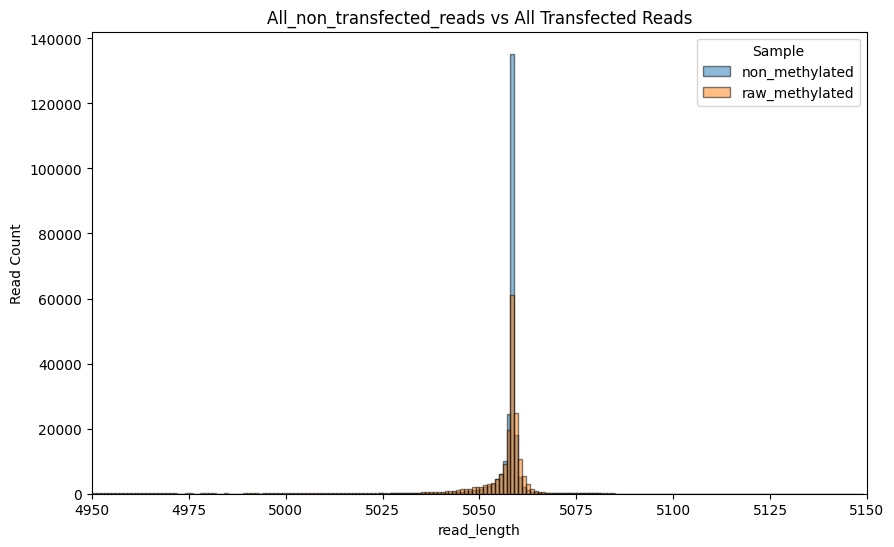

In [ ]:
# Filter the data for the two samples to plot
samples_to_plot = ['non_methylated', 'raw_methylated']
read_length_df_filtered = read_length_df[read_length_df['Sample'].isin(samples_to_plot)]

# Define the bins for the histogram
bins = range(4950, 5150)  # Adjust the range and bin size as needed

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the histograms for each sample
for sample in samples_to_plot:
    sample_data = read_length_df_filtered[read_length_df_filtered['Sample'] == sample]['read_length']
    ax.hist(sample_data, bins=bins, alpha=0.5, label=sample, edgecolor='black')

# Add labels and title
ax.set_xlabel('read_length')
ax.set_ylabel('Read Count')
ax.set_title('All_non_transfected_reads vs All Transfected Reads')
ax.set_xlim(4950, 5150)  # Adjust the x-axis limits as needed

# Add legend
ax.legend(title="Sample")

# Show the plot
# plt.show()

# Save the plot
# fig.savefig('/gscratch/stergachislab/bmallo/large_home/plasmid_fiberseq/paper_figures/figure_1/supplemental/nontransfected_methylated_vs_unmethylated_read_length.svg')

#### Get NPR data

In [11]:
untransfected_all_reads_npr = analyze_bam(untransfected_all_reads, get_npr)
untransfected_length_filtered_npr = analyze_bam(untransfected_length_filtered, get_npr)
untransfected_length_m6a_filtered_npr = analyze_bam(untransfected_length_m6a_filtered, get_npr)

transfected_all_reads_npr = analyze_bam(transfected_all_reads, get_npr)
transfected_length_filtered_npr = analyze_bam(transfected_length_filtered, get_npr)
transfected_length_m6a_filtered_npr = analyze_bam(transfected_length_m6a_filtered, get_npr)

read_count = 304738 mean = 0 mode = 0
read_count = 228840 mean = 0 mode = 0
read_count = 226245 mean = 0 mode = 0
read_count = 305645 mean = 10 mode = 0
read_count = 252765 mean = 11 mode = 0
read_count = 160317 mean = 10 mode = 0


In [4]:
non_methylated_npr = analyze_subsampled_bam(non_methylated_bam, get_npr, num_reads=226245)
raw_methylated_npr = analyze_subsampled_bam(raw_methylated_bam, get_npr, num_reads=226245)
methylated_npr = analyze_subsampled_bam(methylated_bam, get_npr, num_reads=226245)
methylated_npr_filtered = analyze_subsampled_bam(methylated_bam_m6a_filtered, get_npr, num_reads=226245)
raw_pEF_GFP_Hek293_npr = analyze_subsampled_bam(raw_pEF_GFP_Hek293, get_npr, num_reads=226245)
pEF_GFP_Hek293_npr = analyze_subsampled_bam(pEF_GFP_Hek293, get_npr, num_reads=226245)
pEF_GFP_Hek293_npr_filtered = analyze_subsampled_bam(pEF_GFP_Hek293_bam_m6a_filtered, get_npr, num_reads=226245)

4855324235524376
['samtools', 'view', '-s', '1.4855324235524376', '-b', '/gscratch/stergachislab/bmallo/large_home/ft_data/plasmid_fiberseq/non_transfected_plasmid_controls/non_methylated_pEF-GFP/plasmid_bams_processed/pEFGFP/pEFGFP_no_m6a_filter_50_range_exact_reads.bam', '-o', '/tmp/temp_subsample_0.bam']
read_count = 226289 mean = 6 mode = 0
7424246401827144
['samtools', 'view', '-s', '1.7424246401827144', '-b', '/gscratch/stergachislab/bmallo/large_home/ft_data/plasmid_fiberseq/non_transfected_plasmid_controls/methylated_pEF-GFP/plasmid_bams_processed/pEFGFP/all_pEF-GFP_reads.bam', '-o', '/tmp/temp_subsample_0.bam']
read_count = 226206 mean = 0 mode = 0
9886601992658626
['samtools', 'view', '-s', '1.9886601992658626', '-b', '/gscratch/stergachislab/bmallo/large_home/ft_data/plasmid_fiberseq/non_transfected_plasmid_controls/methylated_pEF-GFP/plasmid_bams_processed/pEFGFP/pEFGFP_no_m6a_filter_50_range_exact_reads.bam', '-o', '/tmp/temp_subsample_0.bam']
read_count = 226280 mean = 0 

In [11]:
values = pEF_GFP_Hek293_npr_filtered[0]
percent_less_equal_5 = (sum(1 for v in values if v > 16) / len(values)) * 100
percent_less_equal_5

25.880618882445873

In [80]:
non_methylated_npr[0] = non_methylated_npr[0][:226245]
raw_methylated_npr[0] = raw_methylated_npr[0][:226245]
methylated_npr[0] = methylated_npr[0][:226245]
methylated_npr_filtered[0] = methylated_npr_filtered[0][:226245]
raw_pEF_GFP_Hek293_npr[0] = raw_pEF_GFP_Hek293_npr[0][:226245]
pEF_GFP_Hek293_npr[0] = pEF_GFP_Hek293_npr[0][:226245]
pEF_GFP_Hek293_npr_filtered[0] = pEF_GFP_Hek293_npr_filtered[0][:226245]

In [81]:
samples = ['non_methylated', 'raw_methylated', 'methylated', 'methylated_m6a_filtered', 'raw_pEF_GFP_Hek293','pEF_GFP_Hek293', 'pEF_GFP_Hek293_m6a_filtered']
data_dicts = [non_methylated_npr, raw_methylated_npr, methylated_npr, methylated_npr_filtered, raw_pEF_GFP_Hek293_npr, pEF_GFP_Hek293_npr, pEF_GFP_Hek293_npr_filtered]

# Initialize an empty list to store the data
data = []

# Loop through each sample and its corresponding dictionary
for sample, data_dict in zip(samples, data_dicts):
    for key, values in data_dict.items():
        for value in values:
            data.append({'Sample': sample, 'read_length': value})

# Convert the list of dictionaries to a pandas dataframe
npr_df = pd.DataFrame(data)

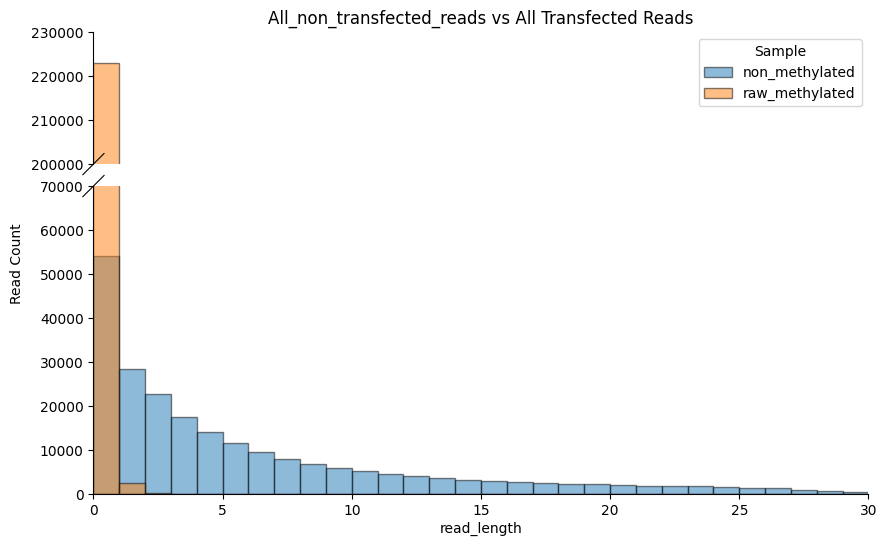

In [106]:
from brokenaxes import brokenaxes

# Filter the data for the two samples to plot
samples_to_plot = ['non_methylated', 'raw_methylated']
npr_df_filtered = npr_df[npr_df['Sample'].isin(samples_to_plot)]

# Define the bins for the histogram
bins = range(0, 31)

# Create the broken y-axis
fig = plt.figure(figsize=(10, 6))
bax = brokenaxes(xlims=((0, 30),), ylims=((0, 70000), (200000, 230000)), hspace=0.1)

# Plot the histograms for each sample
for sample in samples_to_plot:
    sample_data = npr_df_filtered[npr_df_filtered['Sample'] == sample]['read_length']
    bax.hist(sample_data, bins=bins, alpha=0.5, label=sample, edgecolor='black')

# Add labels and title
bax.set_xlabel('read_length', labelpad=20)
bax.set_ylabel('Read Count', labelpad=50)
bax.set_title('All_non_transfected_reads vs All Transfected Reads')

# Add legend
bax.legend(title="Sample")

# Show the plot
# plt.show()

# Save the plot
fig.savefig('/gscratch/stergachislab/bmallo/large_home/plasmid_fiberseq/paper_figures/figure_1/supplemental/non_transfected_methylated_vs_nonmethylated_npr.svg')

In [32]:
# Create a list of sample names and corresponding dictionaries
samples = ['Non-Methylated', 'Raw_Methylated', 'Methylated', 'Methylated (Filtered)', 'Raw_pEF-GFP_Hek293', 'pEF-GFP_Hek293', 'pEF-GFP_Hek293 (Filtered)']
data_dicts = [non_methylated_m6a, raw_methylated_m6a, methylated_m6a, methylated_m6a_filtered, raw_pEF_GFP_Hek293_m6a, pEF_GFP_Hek293_m6a, pEF_GFP_Hek293_m6a_filtered]

# Initialize an empty list to store the data
data = []

# Loop through each sample and its corresponding dictionary
for sample, data_dict in zip(samples, data_dicts):
    for key, values in data_dict.items():
        for value in values:
            data.append({'Sample': sample, 'Percent_m6A': value})

# Convert the list of dictionaries to a pandas dataframe
m6a_df = pd.DataFrame(data)

# Display the dataframe
# print(m6a_df[m6a_df['Sample'] == 'Raw_pEF-GFP_Hek293'])

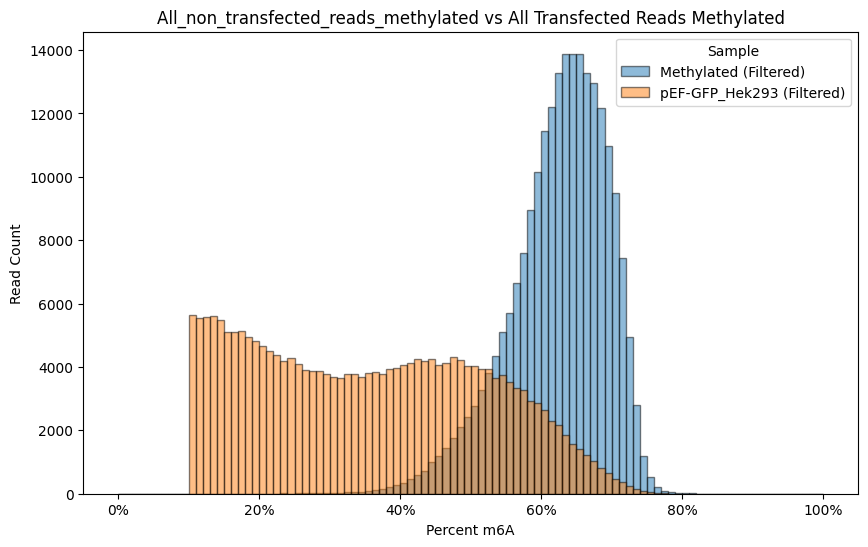

In [42]:
# Filter the data for the two samples to plot
samples_to_plot = ['Methylated (Filtered)', 'pEF-GFP_Hek293 (Filtered)']
m6a_df_filtered = m6a_df[m6a_df['Sample'].isin(samples_to_plot)]

# Define the bins for the histogram
bins = 100
bin_range = (0, 1)  # Assuming Percent_m6A is between 0 and 1

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the histograms for each sample
for sample in samples_to_plot:
    sample_data = m6a_df_filtered[m6a_df_filtered['Sample'] == sample]['Percent_m6A']
    ax.hist(sample_data, bins=bins, range=bin_range, alpha=0.5, label=sample, edgecolor='black')

# Add labels and title
ax.set_xlabel('Percent m6A')
ax.set_ylabel('Read Count')
ax.set_title('All_non_transfected_reads_methylated vs All Transfected Reads Methylated')

# Add legend
ax.legend(title="Sample")

# Change x-axis tick mark labels to be percentages
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0%}'))

# Show the plot
# plt.show()

# Save the plot
fig.savefig('/gscratch/stergachislab/bmallo/large_home/plasmid_fiberseq/paper_figures/figure_1/supplemental/non_transfected_vs_transfected_no_length_m6a_filter.svg')

### Plot NPR

In [5]:
non_methlyated_npr = analyze_subsampled_bam(non_methylated_bam, get_npr, num_reads=226245)
methylated_npr = analyze_subsampled_bam(methylated_bam, get_npr, num_reads=226245)
methylated_npr_filtered = analyze_subsampled_bam(methylated_bam_m6a_filtered, get_npr, num_reads=226245)
pEF_GFP_Hek293_npr = analyze_subsampled_bam(pEF_GFP_Hek293, get_npr, num_reads=226245)
pEF_GFP_Hek293_npr_filtered = analyze_subsampled_bam(pEF_GFP_Hek293_bam_m6a_filtered, get_npr, num_reads=226245)

4855324235524376
['samtools', 'view', '-s', '1.4855324235524376', '-b', '/gscratch/stergachislab/bmallo/large_home/ft_data/plasmid_fiberseq/non_transfected_plasmid_controls/non_methylated_pEF-GFP/plasmid_bams_processed/pEFGFP/pEFGFP_no_m6a_filter_50_range_exact_reads.bam', '-o', '/tmp/temp_subsample_0.bam']
read_count = 226289 mean = 6 mode = 0
9886601992658626
['samtools', 'view', '-s', '1.9886601992658626', '-b', '/gscratch/stergachislab/bmallo/large_home/ft_data/plasmid_fiberseq/non_transfected_plasmid_controls/methylated_pEF-GFP/plasmid_bams_processed/pEFGFP/pEFGFP_no_m6a_filter_50_range_exact_reads.bam', '-o', '/tmp/temp_subsample_0.bam']
read_count = 226280 mean = 0 mode = 0
0
['samtools', 'view', '-s', '1.0', '-b', '/gscratch/stergachislab/bmallo/large_home/ft_data/plasmid_fiberseq/non_transfected_plasmid_controls/methylated_pEF-GFP/plasmid_bams_processed/pEFGFP/pEFGFP_50_range_exact_reads.bam', '-o', '/tmp/temp_subsample_0.bam']
read_count = 226245 mean = 0 mode = 0
37335144162

In [6]:
non_methlyated_npr[0] = non_methlyated_npr[0][:226245]
methylated_npr[0] = methylated_npr[0][:226245]
methylated_npr_filtered[0] = methylated_npr_filtered[0][:226245]
pEF_GFP_Hek293_npr[0] = pEF_GFP_Hek293_npr[0][:226245]
pEF_GFP_Hek293_npr_filtered[0] = pEF_GFP_Hek293_npr_filtered[0][:226245]

In [7]:
# Create a list of sample names and corresponding dictionaries
samples = ['Methylated', 'Non-Methylated', 'Methylated (Filtered)', 'pEF-GFP_Hek293', 'pEF-GFP_Hek293 (Filtered)']
data_dicts = [methylated_npr, non_methlyated_npr, methylated_npr_filtered, pEF_GFP_Hek293_npr, pEF_GFP_Hek293_npr_filtered]

# Initialize an empty list to store the data
data = []

# Loop through each sample and its corresponding dictionary
for sample, data_dict in zip(samples, data_dicts):
    for key, values in data_dict.items():
        for value in values:
            data.append({'Sample': sample, 'npr': value})

# Convert the list of dictionaries to a pandas dataframe
npr_df = pd.DataFrame(data)

# Display the dataframe
npr_df

,Sample,npr
0,Methylated,0
1,Methylated,0
2,Methylated,0
3,Methylated,0
4,Methylated,0
...,...,...
1131220,pEF-GFP_Hek293 (Filtered),2
1131221,pEF-GFP_Hek293 (Filtered),10
1131222,pEF-GFP_Hek293 (Filtered),17
1131223,pEF-GFP_Hek293 (Filtered),8


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

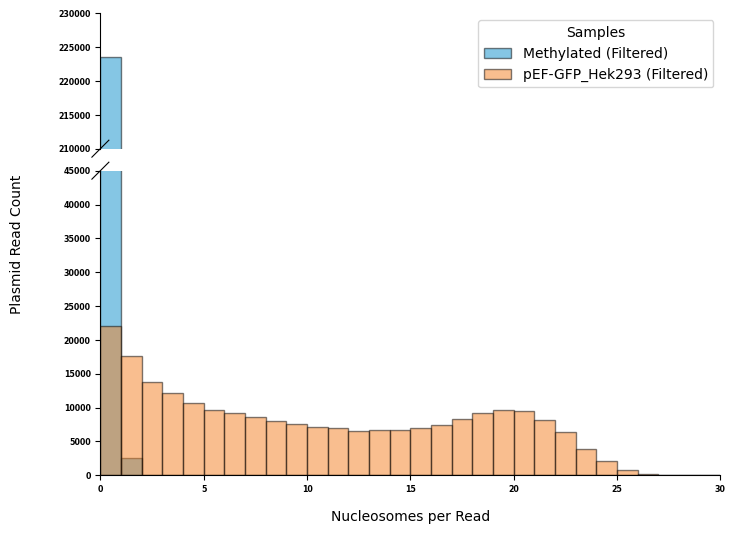

In [30]:
import matplotlib.pyplot as plt

# Define samples to plot
samples_to_plot = ['Methylated (Filtered)', 'pEF-GFP_Hek293 (Filtered)']
colors = {'Methylated (Filtered)': '#0d8eca', 'pEF-GFP_Hek293 (Filtered)': '#f57f20'}

# Filter the DataFrame
filtered_df = npr_df[npr_df["Sample"].isin(samples_to_plot)]

# Create the broken y-axis
fig = plt.figure(figsize=(8, 6))
bax = brokenaxes(xlims=((0, 30),), ylims=((0, 45000), (210000, 230000)), hspace=0.1)

# Define the bins for the histogram
bins = range(0, 31)

# Plot data for each sample with the same bins
for sample in samples_to_plot:
	sample_data = filtered_df[filtered_df["Sample"] == sample]["npr"]
	bax.hist(sample_data, bins=bins, alpha=0.5, label=sample, edgecolor='black', color=colors[sample])

# Formatting
bax.legend(title="Samples")
bax.set_xlabel("Nucleosomes per Read", labelpad=25)  # Increase labelpad for x-axis
bax.set_ylabel("Plasmid Read Count", labelpad=55)    # Increase labelpad for y-axis

# Set tick mark labels to Arial Bold 5.7pt font
for ax in bax.axs:
	ax.tick_params(axis='both', which='major', labelsize=5.7, labelcolor='black')
	for label in ax.get_xticklabels() + ax.get_yticklabels():
		label.set_fontname('Arial')
		label.set_fontweight('bold')

plt.savefig('/gscratch/stergachislab/bmallo/large_home/plasmid_fiberseq/paper_figures/figure_1/figure_1C_broekenaxes.pdf', format='pdf')


In [90]:
plt.savefig('/gscratch/stergachislab/bmallo/large_home/plasmid_fiberseq/paper_figures/figure_1/figure_1C_broekenaxes.svg', format='svg')

<Figure size 640x480 with 0 Axes>